In [61]:
# Download the relevant modules:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from deepxde.callbacks import EarlyStopping
from numba import njit, jit
import deepxde as dde

<deepxde.icbc.initial_conditions.IC object at 0x000001A21094B550> <deepxde.icbc.boundary_conditions.PeriodicBC object at 0x000001A23FB6FED0> <deepxde.icbc.boundary_conditions.PeriodicBC object at 0x000001A23FE084D0>
Compiling model...
Building feed-forward neural network...
'build' took 0.055710 s

'compile' took 1.252124 s

Training model...

0         [1.00e+10, 5.82e+00, 7.28e+00]    [1.00e+10, 5.82e+00, 7.28e+00]    []  
1000      [3.40e+07, 1.27e+04, 2.00e+04]    [3.40e+07, 1.27e+04, 2.00e+04]    []  
2000      [4.93e+07, 6.68e+03, 1.41e+04]    [4.93e+07, 6.68e+03, 1.41e+04]    []  
3000      [8.98e+07, 6.76e+03, 1.54e+04]    [8.98e+07, 6.76e+03, 1.54e+04]    []  
4000      [1.86e+07, 6.65e+03, 1.51e+04]    [1.86e+07, 6.65e+03, 1.51e+04]    []  
5000      [4.13e+06, 7.46e+03, 1.34e+04]    [4.13e+06, 7.46e+03, 1.34e+04]    []  
6000      [1.03e+07, 6.74e+03, 1.34e+04]    [1.03e+07, 6.74e+03, 1.34e+04]    []  
7000      [8.54e+06, 6.91e+03, 1.37e+04]    [8.54e+06, 6.91e+03, 1.37e+04

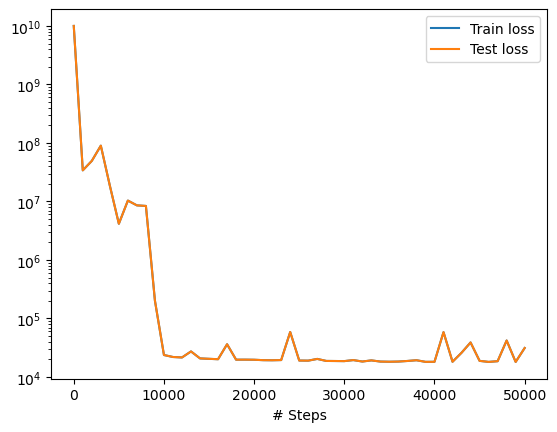

In [71]:
# Generate the Parameters:

# Reaction rate constant
kappa = 0.1  # Example value, adjust as needed
Q_11 = 100
Q_12 = 10
Q_21 = 100
Q_22 = 10

Source_function = lambda x: 1e4

# Define the PDE
def pde(x, y):
    T = y[:, 0:1]
    dT_dt = dde.grad.jacobian(y, x, i=0, j=2)
    dT_dx = dde.grad.jacobian(y, x, i=0, j=0)
    dT_dy = dde.grad.jacobian(y, x, i=0, j=1)
    d2T_dx2 = dde.grad.hessian(y, x, i=0, j=0)
    d2T_dy2 = dde.grad.hessian(y, x, i=0, j=1)

    # Anisotropic diffusion terms
    diffusive_term = Q_11 * d2T_dx2 + (Q_12 + Q_21) * dT_dx * dT_dy + Q_22 * d2T_dy2
    # Reaction term (e.g., linear decay term -kappa * T)
    reaction_term = -kappa * T

    # Source term S (needs to be defined)
    S = Source_function(x)

    return dT_dt - diffusive_term + reaction_term + S

# Define the computational domain, here as a placeholder: a square domain [0, 1] x [0, 1]
geom = dde.geometry.Rectangle([0, 0], [2*np.pi, 2*np.pi])

# Time domain
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition: T = 0 at t = 0
ic = dde.IC(geomtime, lambda x: np.zeros((len(x), 1)), lambda _, on_initial: on_initial)

# Create periodic boundary conditions objects

def boundary_xr(x, on_boundary):
        return on_boundary and np.isclose(x[0], 2*np.pi)

def boundary_xl(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_yr(x, on_boundary):
        return on_boundary and np.isclose(x[1], 2*np.pi)

def boundary_yl(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)


bc1x = dde.PeriodicBC(geomtime, 0, boundary_xr, component=0)
bc2x = dde.PeriodicBC(geomtime, 0, boundary_xl, component=0)

bc1y = dde.PeriodicBC(geomtime, 0, boundary_yr, component=1)
bc2y = dde.PeriodicBC(geomtime, 0, boundary_yl, component=1)


def fun_bc0(x):
        return x[0, 1:]

def fun_bc1(x):
        return x[1, 1:]

def boundary(x, on_boundary):
        return on_boundary


bc_3 = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

# Define the data for the PDE problem
data = dde.data.TimePDE(geomtime, pde, [ic, bc_3], num_domain=1000, num_boundary=100, num_initial=100)

# Callbacks
# Callback for early stopping
# Stop training if validation loss doesn't improve for 1000 consecutive epochs
early_stopping = EarlyStopping(patience=20000, verbose=True)


# Neural network configuration
net = dde.maps.FNN([3] + [32]*5 + [1], "relu", "He normal")

# Model setup
model = dde.Model(data, net)

# Model training
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=50000, callbacks = [early_stopping])
print(losshistory, train_state)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.045661 s



c:\Users\kdarn\anaconda3\envs\TenseNeuralNets\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.671289 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e+08, 7.42e+00, 1.73e+00, 2.52e+01]    [1.01e+08, 7.42e+00, 1.73e+00, 2.52e+01]    []  
1000      [2.74e+06, 1.41e+03, 3.91e+03, 4.77e+03]    [2.74e+06, 1.41e+03, 3.91e+03, 4.77e+03]    []  
2000      [6.86e+05, 1.09e+03, 2.57e+03, 4.10e+03]    [6.86e+05, 1.09e+03, 2.57e+03, 4.10e+03]    []  
3000      [1.46e+06, 6.58e+02, 1.45e+03, 1.29e+03]    [1.46e+06, 6.58e+02, 1.45e+03, 1.29e+03]    []  
4000      [3.77e+05, 9.17e+02, 8.80e+02, 1.36e+03]    [3.77e+05, 9.17e+02, 8.80e+02, 1.36e+03]    []  
5000      [1.43e+06, 7.40e+02, 9.01e+02, 1.23e+03]    [1.43e+06, 7.40e+02, 9.01e+02, 1.23e+03]    []  
6000      [2.25e+06, 1.10e+03, 6.28e+02, 6.78e+02]    [2.25e+06, 1.10e+03, 6.28e+02, 6.78e+02]    []  
7000      [2.30e+06, 1.35e+03, 2.87e+02, 3.71e+02]    [2.30e+06, 1.35e+03, 2.87e+02, 3.71e+02]    []  
8000      [2.50e+06,

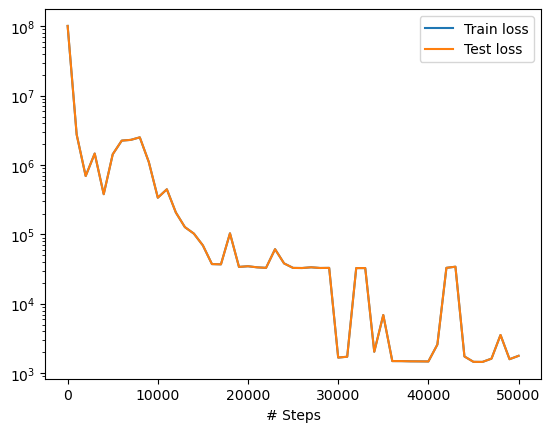

In [75]:
# Generate the Parameters:

# Reaction rate constant
kappa = 0.1  # Example value, adjust as needed
Q_11 = 100
Q_12 = 10
Q_21 = 100
Q_22 = 10

Source_function = lambda x: 1e4

# Define the PDE
def pde(x, y):
    T = y[:, 0:1]
    dT_dt = dde.grad.jacobian(y, x, i=0, j=2)
    dT_dx = dde.grad.jacobian(y, x, i=0, j=0)
    dT_dy = dde.grad.jacobian(y, x, i=0, j=1)
    d2T_dx2 = dde.grad.hessian(y, x, i=0, j=0)
    d2T_dy2 = dde.grad.hessian(y, x, i=0, j=1)

    # Anisotropic diffusion terms
    diffusive_term = Q_11 * d2T_dx2 + (Q_12 + Q_21) * dT_dx * dT_dy + Q_22 * d2T_dy2
    # Reaction term (e.g., linear decay term -kappa * T)
    reaction_term = -kappa * T

    # Source term S (needs to be defined)
    S = Source_function(x)

    return dT_dt - diffusive_term + reaction_term + S

# Define the computational domain, here as a placeholder: a square domain [0, 1] x [0, 1]
geom = dde.geometry.Rectangle([0, 0], [2*np.pi, 2*np.pi])

# Time domain
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition: T = 0 at t = 0
ic = dde.IC(geomtime, lambda x: np.zeros((len(x), 1)), lambda _, on_initial: on_initial)

# Create periodic boundary conditions objects

def boundary_xr(x, on_boundary):
        return on_boundary and np.isclose(x[0], 2*np.pi)

def boundary_xl(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_yr(x, on_boundary):
        return on_boundary and np.isclose(x[1], 2*np.pi)

def boundary_yl(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)


bc1x = dde.PeriodicBC(geomtime, 0, boundary_xr, component=0)
bc2x = dde.PeriodicBC(geomtime, 0, boundary_xl, component=0)

bc1y = dde.PeriodicBC(geomtime, 0, boundary_yr, component=1)
bc2y = dde.PeriodicBC(geomtime, 0, boundary_yl, component=1)


def boundary(x, on_boundary):
        return on_boundary


def func_bdy(x):
       return np.zeros([len(x), 1])

bc_1 = dde.DirichletBC(geomtime, func_bdy, boundary)
bc_2 = dde.DirichletBC(geomtime, func_bdy, boundary_xr)
bc_3 = dde.DirichletBC(geomtime, func_bdy, boundary_yr)

# Define the data for the PDE problem
data = dde.data.TimePDE(geomtime, pde, [ic, bc_2, bc_3], num_domain=3000, num_boundary=100, num_initial=100)

# Callbacks
# Callback for early stopping
# Stop training if validation loss doesn't improve for 1000 consecutive epochs
early_stopping = EarlyStopping(min_delta= 1e-4, patience = 20000)

# Neural network configuration
net = dde.maps.FNN([3] + [32]*5 + [1], "relu", "He normal")

# Model setup
model = dde.Model(data, net)

# Model training
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=50000, callbacks = [early_stopping])
print(losshistory, train_state)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

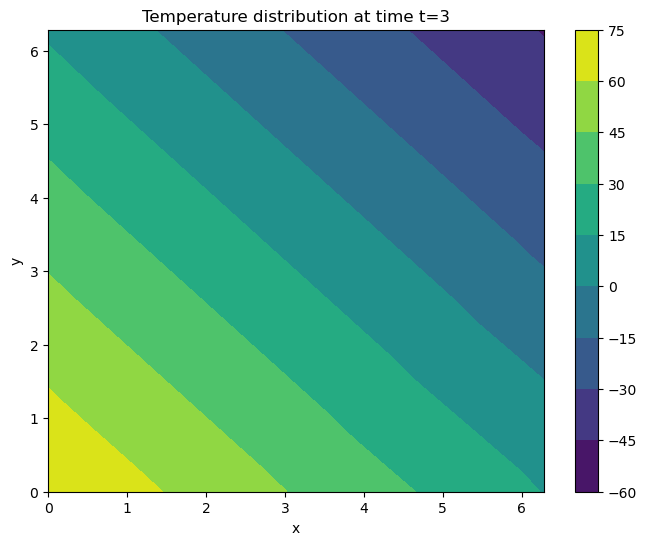

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose your domain is a 2D space (x, y) and you're interested in the solution at a specific time t
t = 3# the time at which you want to evaluate the solution
x = np.linspace(0, 2*np.pi, 200)  # 100 points along the x-axis
y = np.linspace(0, 2*np.pi, 200)  # 100 points along the y-axis
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T  # prepare points for predict

# Perform inference
predicted_values = model.predict(points)

# Reshape the predicted values for visualization
T_predicted = predicted_values.reshape(X.shape)

# Visualize the predicted temperature distribution at time t
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_predicted, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Temperature distribution at time t={t}')
plt.show()


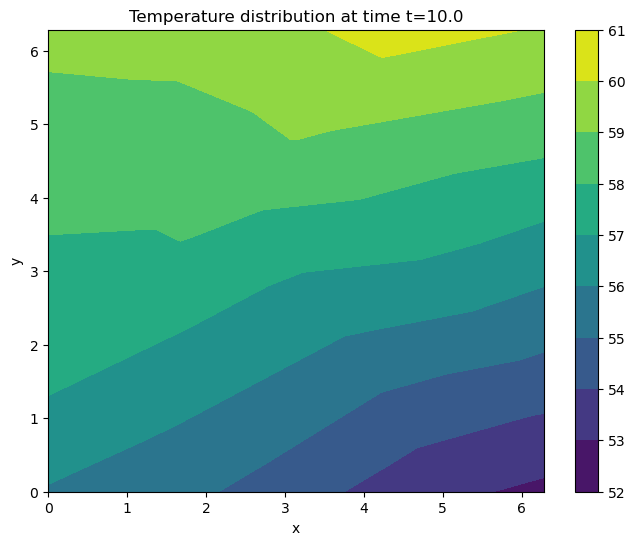

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose your domain is a 2D space (x, y) and you're interested in the solution at a specific time t
t = 10.0# the time at which you want to evaluate the solution
x = np.linspace(0, 2*np.pi, 200)  # 100 points along the x-axis
y = np.linspace(0, 2*np.pi, 200)  # 100 points along the y-axis
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T  # prepare points for predict

# Perform inference
predicted_values = model.predict(points)

# Reshape the predicted values for visualization
T_predicted = predicted_values.reshape(X.shape)

# Visualize the predicted temperature distribution at time t
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_predicted, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Temperature distribution at time t={t}')
plt.show()


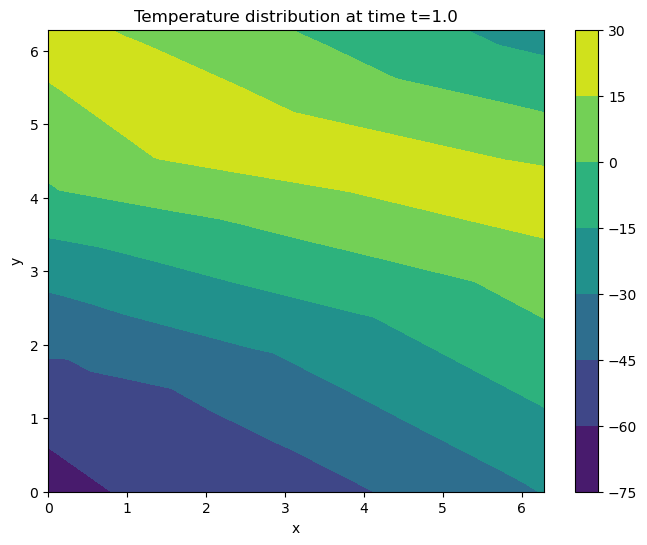

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose your domain is a 2D space (x, y) and you're interested in the solution at a specific time t
t = 1.0# the time at which you want to evaluate the solution
x = np.linspace(0, 2*np.pi, 200)  # 100 points along the x-axis
y = np.linspace(0, 2*np.pi, 200)  # 100 points along the y-axis
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T  # prepare points for predict

# Perform inference
predicted_values = model.predict(points)

# Reshape the predicted values for visualization
T_predicted = predicted_values.reshape(X.shape)

# Visualize the predicted temperature distribution at time t
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_predicted, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Temperature distribution at time t={t}')
plt.show()


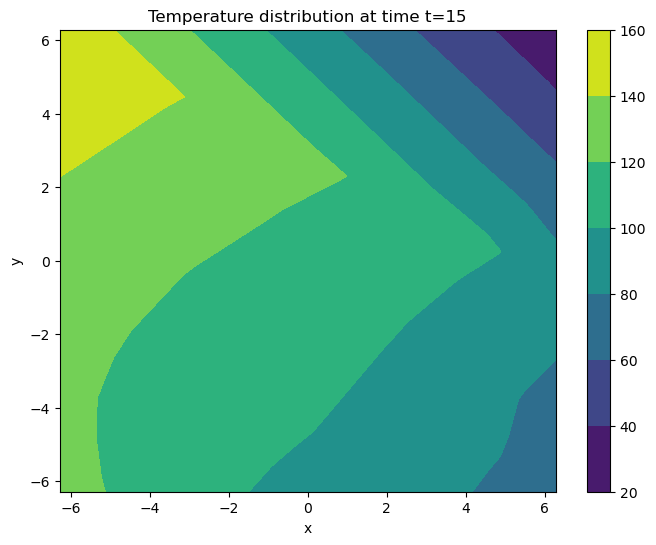

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose your domain is a 2D space (x, y) and you're interested in the solution at a specific time t
t = 15# the time at which you want to evaluate the solution
x = np.linspace(-2*np.pi, 2*np.pi, 200)  # 100 points along the x-axis
y = np.linspace(-2*np.pi, 2*np.pi, 200)  # 100 points along the y-axis
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T  # prepare points for predict

# Perform inference
predicted_values = model.predict(points)

# Reshape the predicted values for visualization
T_predicted = predicted_values.reshape(X.shape)

# Visualize the predicted temperature distribution at time t
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_predicted, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Temperature distribution at time t={t}')
plt.show()


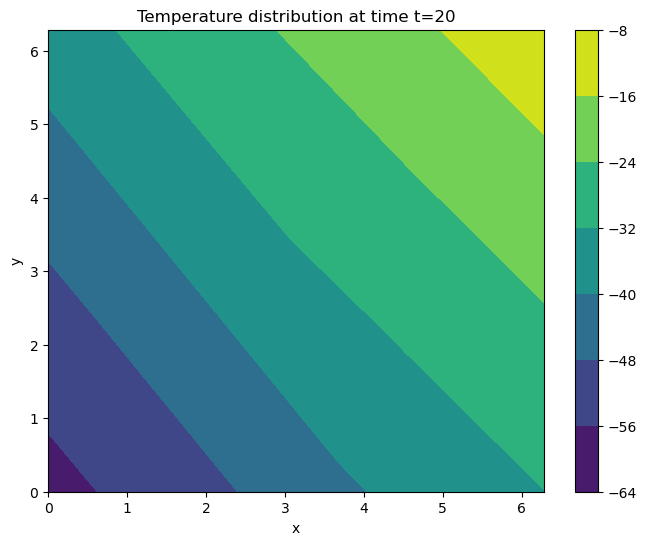

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose your domain is a 2D space (x, y) and you're interested in the solution at a specific time t
t = 20  # the time at which you want to evaluate the solution
x = np.linspace(0, 2*np.pi, 200)  # 100 points along the x-axis
y = np.linspace(0, 2*np.pi, 200)  # 100 points along the y-axis
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T  # prepare points for predict

# Perform inference
predicted_values = model.predict(points)

# Reshape the predicted values for visualization
T_predicted = predicted_values.reshape(X.shape)

# Visualize the predicted temperature distribution at time t
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_predicted, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Temperature distribution at time t={t}')
plt.show()


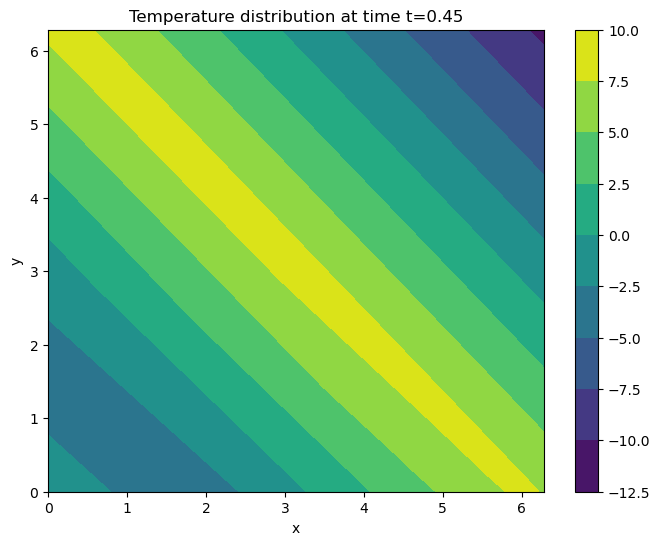

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose your domain is a 2D space (x, y) and you're interested in the solution at a specific time t
t = 0.45 # the time at which you want to evaluate the solution
x = np.linspace(0, 2*np.pi, 200)  # 100 points along the x-axis
y = np.linspace(0, 2*np.pi, 200)  # 100 points along the y-axis
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten(), np.full_like(X.flatten(), t))).T  # prepare points for predict

# Perform inference
predicted_values = model.predict(points)

# Reshape the predicted values for visualization
T_predicted = predicted_values.reshape(X.shape)

# Visualize the predicted temperature distribution at time t
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, T_predicted, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Temperature distribution at time t={t}')
plt.show()